In [1]:
!pip install tensorflow==2.3

In [21]:
!pip install retry

     |████████████████████████████████| 97 kB 2.2 MB/s eta 0:00:01


Using https://www.kaggle.com/cyannani123/keras-cellular-image-classification as test example

In [2]:
import os

In [3]:
import sys

In [4]:
sys.executable

'/anaconda/envs/azureml_py36/bin/python'

In [5]:
import numpy as np
import pandas as pd

In [6]:
import tensorflow as tf

In [7]:
tf.__version__

'2.3.0'

In [8]:
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB1

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
from tensorflow.python.client import device_lib

In [11]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2089494089044984178
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17099017893620065493
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6775285836850586927
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11142594560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8623122036182411187
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7"
]


In [12]:
import tensorflow.keras as keras

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.utils import Sequence

In [15]:
import os, sys, random,copy
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFilter
from sklearn.model_selection import train_test_split

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

Loading test and train data.

Will load directly from zip for now.

In [17]:
test_data = pd.read_csv("./input/recbio/test.csv")
print("Shape of test_data:", test_data.shape)
test_data.head()

Shape of test_data: (19899, 4)


,id_code,experiment,plate,well
0,HEPG2-08_1_B03,HEPG2-08,1,B03
1,HEPG2-08_1_B04,HEPG2-08,1,B04
2,HEPG2-08_1_B05,HEPG2-08,1,B05
3,HEPG2-08_1_B06,HEPG2-08,1,B06
4,HEPG2-08_1_B07,HEPG2-08,1,B07


In [18]:
train_data = pd.read_csv("./input/recbio/train.csv")
print("Shape of test_data:", test_data.shape)
train_data.head()

Shape of test_data: (19899, 4)


,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,sirna_250
1,HEPG2-01_1_B04,HEPG2-01,1,B04,sirna_62
2,HEPG2-01_1_B05,HEPG2-01,1,B05,sirna_1115
3,HEPG2-01_1_B06,HEPG2-01,1,B06,sirna_602
4,HEPG2-01_1_B07,HEPG2-01,1,B07,sirna_529


In [19]:
sirna_label_encoder = LabelEncoder().fit(train_data.sirna)

In [22]:
from retry import retry

In [153]:
@retry(tries=3)
def get_input(experiment, plate, well, site, channel, train=True):
    
    if train==True:
        base_path = './input/recbio/train'
    else:
        base_path = './input/recbio/test'
    
    try:
        path = f"{base_path}/{experiment}/Plate{plate}/{well}_s{str(site)}_w{str(channel)}.png"
        img = Image.open(path)
    except FileNotFoundError as err:
        print(f"Error loading input - {err}")
        print("Will default to other site")
        
        # hack mis aitab kahe puuduva pildi puhul
        # pm kui puudub pilt siis proovib lihtsalt teist saiti võtta
        if site==2:
            path = f"{base_path}/{experiment}/Plate{plate}/{well}_s1_w{str(channel)}.png"
            img = Image.open(path)
        else:
            path = f"{base_path}/{experiment}/Plate{plate}/{well}_s2_w{str(channel)}.png"
            img = Image.open(path)
    
    return img

Saidid on samast wellist tehtud eri pildid. Pm võib võtta ainult ühe saidi sisse.
Channelid on eri kanalitega tehtud pildid. Neid on kokku 6.

Kirjutan piltide laadimise klassi notebooki näitel

In [56]:
def augment(image):
    random_transform = random.randint(-1,4)
    if random_transform==0:
        image = image.rotate(random.randint(-5,5))
    if random_transform==1:
        image = image.filter(ImageFilter.GaussianBlur(radius=1))
    if random_transform==2:
        image = image.filter(ImageFilter.RankFilter(size=3, rank=1))
    if random_transform==3:
        image = image.filter(ImageFilter.MedianFilter(size=3))
    if random_transform==4:
        image = image.filter(ImageFilter.MaxFilter(size=3))
    return image


In [139]:
def get_center_box(image, shape_w_h=(224,224)):
    
    cropbox = (144, 144, 144 + shape_w_h[0], 144 + shape_w_h[1])
    
    return image.crop(cropbox)
    

In [128]:
def get_random_subbox(image, shape_w_h=(224,224)):
    
    w = image.width
    h = image.height
    
    print(f"Image w, h: {w},{h}")
    
    random_w = random.randint(0, w - shape_w_h[0])
    random_h = random.randint(0, h - shape_w_h[1])
    
    cropbox = (random_w, random_h, random_w + shape_w_h[0], random_h + shape_w_h[1])
    
    print(f"Random cropbox: {cropbox}")
    
    cropped = image.crop( cropbox )
    
    print(f"Cropped image w, h: {cropped.width}, {cropped.height}")
    
    return cropped
    
    
    

In [156]:
class ImgGen(Sequence):
    def __init__(self, label_data, batch_size = 32, preprocess=(lambda x: x), shuffle=False):
    
        if shuffle:
            self.label_data=label_data.sample(frac=1).reset_index(drop=True)
        else:
            self.label_data=label_data
        
        self.batch_size=batch_size
        self.preprocess=preprocess
        
    def __len__(self):
        return int(np.ceil(len(self.label_data))/float(self.batch_size))

    def __getitem__(self, i):
        
        batch_x = self.label_data.loc[i*self.batch_size:(i+1)*self.batch_size,("experiment","plate","well")]
        batch_y = self.label_data.loc[i*self.batch_size:(i+1)*self.batch_size,("sirna")]
        
        x_s1_c1 = [np.array(self.preprocess(get_input(e, p, w, site=1, channel=1)))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c2 = [np.array(self.preprocess(get_input(e, p, w, site=1, channel=2)))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c3 = [np.array(self.preprocess(get_input(e, p, w, site=1, channel=3)))/255 for e, p, w in batch_x.values.tolist()]
        
        x_s1_c4 = [np.array(self.preprocess(get_input(e, p, w, site=1, channel=4)))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c5 = [np.array(self.preprocess(get_input(e, p, w, site=1, channel=5)))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c6 = [np.array(self.preprocess(get_input(e, p, w, site=1, channel=6)))/255 for e, p, w in batch_x.values.tolist()]

        x1 = np.array([x_s1_c1,x_s1_c2,x_s1_c3]).transpose((1,2,3,0))
        x2 = np.array([x_s1_c4,x_s1_c5,x_s1_c6]).transpose((1,2,3,0))
        
        y = sirna_label_encoder.transform(batch_y)
        
        return [np.array(x1), np.array(x2)], y
        
        
       

In [157]:
train = ImgGen(train_data, preprocess=get_center_box)

In [158]:
len(train)

1141

In [159]:
first_batch=train[0]

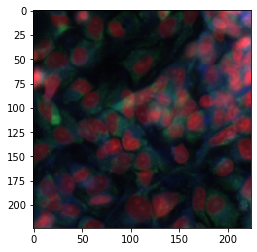

In [160]:
first_image_channels_1_3 = first_batch[0][0][0]
plt.imshow(first_image_channels_1_3, interpolation='nearest')

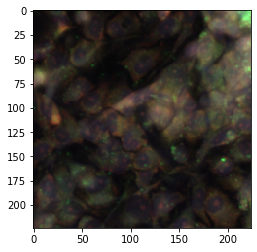

In [161]:
first_image_channels_4_6 = first_batch[0][1][0]
plt.imshow(first_image_channels_4_6, interpolation='nearest')

In [162]:
def create_model():
    effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
    site1 = Input(shape=(224,224,3))
    site2 = Input(shape=(224,224,3))
    x = effnet(site1)
    x = GlobalAveragePooling2D()(x)
    x = Model(inputs=site1, outputs=x)
    y = effnet(site2)
    y = GlobalAveragePooling2D()(y)
    y = Model(inputs=site2, outputs=y)
    combined = concatenate([x.output, y.output])
    z = Dropout(0.5)(combined)
    z = Dense(1108, activation='softmax')(z)
    model = Model(inputs=[x.input, y.input], outputs=z)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    model.summary()
    
    return model

model = create_model()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 7, 7, 1280)   4049571     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 1280)         0           efficientnetb0[0][0] 

Training model

In [163]:
test_size = 0.025
batch_size = 32

In [164]:
train, val = train_test_split(train_data, test_size=test_size)

In [165]:
print(f"Training set size {len(train)}")
print(f"Validation set size {len(val)}")

Training set size 35604
Validation set size 913


In [166]:
train_gen = ImgGen(train,batch_size=batch_size,preprocess=get_center_box,shuffle=True)
val_gen = ImgGen(val,batch_size=batch_size,preprocess=get_center_box,shuffle=True)

In [167]:
print(f"Training set batched size {len(train_gen)}")
print(f"Validation set batched size {len(val_gen)}")

Training set batched size 1112
Validation set batched size 28


In [168]:
filepath = 'ModelCheckpoint_all.h5'

In [169]:
callback = [
        ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        ]

In [170]:
history = model.fit(train_gen, 
                              steps_per_epoch=len(train)//batch_size, 
                              epochs=1, 
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=len(val)//batch_size,
                              callbacks=callback
                             )

  15/1112 [..............................] - ETA: 7:15:01 - loss: 7.1001 - accuracy: 0.0000e+00

KeyboardInterrupt: 